---
**License**

 cmp_cluster_ccl_numcosmo

 Wen Aug 07 15:11:00 2024\
 Copyright  2024\
 Henrique Cardoso Naves Lettieri  <henrique.cnl23@uel.br>
 Mariana Penna-Lima     <pennalima@gmail.com> \
 Sandro Dias Pinto Vitenti <vitenti@uel.br>

---
---

 cmp_cluster_ccl_numcosmo\
 Copyright (C) 2021 Henrique Cardoso Naves Lettieri  <henrique.cnl23@uel.br>, Mariana Penna-Lima <pennalima@gmail.com>, Sandro Dias Pinto Vitenti <vitenti@uel.br>

 numcosmo is free software: you can redistribute it and/or modify it
 under the terms of the GNU General Public License as published by the
 Free Software Foundation, either version 3 of the License, or
 (at your option) any later version.

 numcosmo is distributed in the hope that it will be useful, but
 WITHOUT ANY WARRANTY; without even the implied warranty of
 MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.
 See the GNU General Public License for more details.

 You should have received a copy of the GNU General Public License along
 with this program.  If not, see <http://www.gnu.org/licenses/>.
 
---

<a class="anchor" id="contents"></a>
# Contents

### 1. [Packages](#libraries)
### 2. [Cosmological models](#constants)
### 3. [Halo mass function](#mass)
### 4. [Unbinned approach](#unbinned)
####     4.1 [Mock catalog](#mock)
####     4.2 [NumCosmo predictions](#numcosmo_ubinned)
####     4.3 [CCL preditictios](#ccl_unbinned)
####     4.4 [Relative error plots](#plots_unbinned)
### 5. [Binned approach](#binned)
####     5.1 [Bins](#bins)
####     5.2 [NumCosmo predictions](#numcosmo_binned)
####     5.3 [CCL preditictios](#ccl_binned)
####     5.4 [Relative error plots](#plots_binned)

<a class="anchor" id="libraries"></a>
## 1.  [Packages](#libraries)
***

In the cell below, we import the libraries `CCL` and `NumCosmo` for comparison between their cluster counts predictions in an unbinned and binned true table analyses.

To import `NumCosmo`, we should import `GObject`. This is important because `GObject` help us to maps the C language in other languages, like python.

The package `sys` is related to the manipulation and obtaining information from the python environment imports the auxiliary library `CLCosmo_Sim` to run the binned counts version of `CCL`. The package `numpy` help us with the calculations, gives us access to mathematical functions, while astropy is used too handle the fits files for the cluster mock catalog.



In [1]:
#!/usr/bin/env python
from numcosmo_py import Ncm, Nc
from numcosmo_py.external.pyssc import pyssc as PySSC
from numcosmo_py.ccl import nc_ccl

Ncm.cfg_init()
Ncm.cfg_set_log_handler(lambda msg: sys.stdout.write(msg) and sys.stdout.flush())
import numpy as np
from matplotlib import pyplot as plt
from astropy.io import fits
from astropy.table import Table


import pyccl as ccl

get_ipython().run_line_magic("load_ext", "autoreload")
get_ipython().run_line_magic("autoreload", "2")

import sys

sys.path.insert(0, "../../../CLCosmo_Sim/modeling/")
sys.path.insert(0, "../../../CLCosmo_Sim/modeling/old_files/")
# import CL_COUNT_modeling_halo_mass_function as hmf
# import CL_COUNT_cluster_abundance as cl_count
# import old_CL_COUNT_class_cluster_abundance as old_cl_count

import time

<a class="anchor" id="constants"></a>
## 2. [Cosmological models](#constants)
***
In this cell below we fix the cosmological constants to avoid conflits in the calculations and comparisons between the libraries.


$\Omega_{C}$ = 0.265 The density fraction at z=0 of CDM.<br>
$\Omega_{b}$ = 0.0448 The density fraction at z=0 of baryons.<br>
$\Omega_{k}$ = 0.0 The curvature density fraction at z=0.<br>
$H_{0 }$ = 71.00   The Hubble constant.<br>
$Tcmb_{0}$  = 2.7255 The temperature at z=0 of CMB.<br>
$\sigma_{8}$ = 0.80 The normalization of the power spectrum today. <br>
$n_{s}$ = 0.96 Scalar spectral index.<br>
$N_{eff}$ = 0.0 3.046 effective number of massless+massive neutrinos present at recombination.<br>
$\omega_{0}$ = -1.0 First order term of the dark energy equation of state.<br>
$\omega_{a}$ = 0.0 Second order term of the dark energy equation of state.<br>


In [2]:
# CCL cosmology default paramters
cosmo_ccl_default = ccl.Cosmology(
    Omega_c=0.265,
    Omega_b=0.0448,
    h=0.71,
    sigma8=0.8,
    n_s=0.96,
    Omega_k=0,
    transfer_function="eisenstein_hu",
)


# CCL cosmology high precision paramters
ccl_params = nc_ccl.CCLParams()
ccl_params.set_high_prec_params()

cosmo_ccl_high = ccl.Cosmology(
    Omega_c=0.265,
    Omega_b=0.0448,
    h=0.71,
    sigma8=0.8,
    n_s=0.96,
    Omega_k=0,
    transfer_function="eisenstein_hu",
)

# NumCosmo Cosmology
nc_cosmo = nc_ccl.create_nc_obj(cosmo_ccl_default)

cosmo_numcosmo = nc_cosmo.cosmo
dist = nc_cosmo.dist
psf = nc_cosmo.psf_tophat

<a class="anchor" id="mass"></a>
## 3.  [Halo Mass Function](#mass)
***
In the cell above we initialize the halo mass function objects in both `NumCosmo` and `CCL`

In [3]:
# Numcosmo Halo mass function

# First we define the mass proxy in the first analysis is used the true mass and redshift of the clusters
cluster_m = Nc.ClusterMassNodist(lnM_min=np.log(10) * 14.0, lnM_max=np.log(10) * 16.0)
cluster_z = Nc.ClusterRedshiftNodist(z_min=0.0, z_max=2.0)

sky_area = 5264.05 * (np.pi / 180) ** 2

mulf = Nc.MultiplicityFuncTinker.new()
mulf.set_linear_interp(True)
mulf.set_mdef(Nc.MultiplicityFuncMassDef.CRITICAL)
mulf.set_Delta(200)

hmf_numcosmo = Nc.HaloMassFunction.new(dist, psf, mulf)
hmf_numcosmo.set_area(sky_area)

ca = Nc.ClusterAbundance.new(hmf_numcosmo, None)

mset = Ncm.MSet.new_array([cosmo_numcosmo, cluster_m, cluster_z])
mset.pretty_log()
print("sigma8 = " + str(cosmo_numcosmo.sigma8(psf)))

# CCL halo mass funtion
massdef = ccl.halos.massdef.MassDef(200, "critical")
hmf_ccl = ccl.halos.hmfunc.MassFuncTinker08(mass_def=massdef)

#----------------------------------------------------------------------------------
# Model[03000]:
#   - NcHICosmo : Chevalier-Polarski-Linder parametrization
#----------------------------------------------------------------------------------
# Model parameters
#   -         H0[00]:  71                  [FIXED]
#   -     Omegac[01]:  0.265               [FIXED]
#   -     Omegak[02]:  0                   [FIXED]
#   -    Tgamma0[03]:  2.7255              [FIXED]
#   -         Yp[04]:  0.24544723356242    [FIXED]
#   -       ENnu[05]:  3.044               [FIXED]
#   -     Omegab[06]:  0.0448              [FIXED]


#   -         w0[07]: -1                   [FIXED]
#   -         w1[08]:  0                   [FIXED]
#----------------------------------------------------------------------------------
# Model[05000]:
#   - NcHIPrim : Power Law model for primordial spectra
#----------------------------------------------------------------------------------
# Model parameters
#   - ln10e10ASA[00]:  2.81857454954153    [FIXED]
#   - T_SA_ratio[01]:  0.2                 [FIXED]
#   -       n_SA[02]:  0.96                [FIXED]
#   -        n_T[03]:  0                   [FIXED]
#----------------------------------------------------------------------------------
# Model[07000]:
#   - NcClusterMass : No mass distribution
#----------------------------------------------------------------------------------
# Model parameters
#----------------------------------------------------------------------------------
# Model[08000]:
#   - NcClusterRedshift : No redshift distribution
#-------------------------------------

<a class="anchor" id="unbinned"></a>
## 4.  [Unbinned approach](#unbinned)
***
In the cells above we compute

 $$\frac{d^2V(z_i)}{dz d\Omega}\frac{dn(M_i,z_i)}{d\log_{10}M_i}$$ for each masses and redshifts in a dark matter halo catalog

<a class="anchor" id="mock"></a>
### 4.1 [Mock catalog](#mock)

In the cell below we created a the mock catalog to compare the predictions in the unbinned case

In [4]:
# Generates cluster count catalog data
ncdata = Nc.DataClusterNCount.new(ca, "NcClusterRedshiftNodist", "NcClusterMassNodist")
rng = Ncm.RNG.pool_get("example_ca_sampling")
ncdata.init_from_sampling(mset, sky_area, rng)
ncdata.catalog_save("ca_nodist_unbinned_numcosmo.fits", True)

ncdata_fits = fits.open("ca_nodist_unbinned_numcosmo.fits")
# ncdata_fits.info()

ncdata_data = ncdata_fits[1].data

ncdata_Table = Table(ncdata_data)
ncdata_Table.columns
ncdata_Table.sort("Z_TRUE")

display(ncdata_Table)

Z_OBS,LNM_OBS,Z_TRUE,LNM_TRUE
float64,float64,float64,float64
0.007890346272660442,32.3663515960437,0.007890346272660442,32.3663515960437
0.015591514811768306,34.04155180126926,0.015591514811768306,34.04155180126926
0.01717599338712443,32.537203615525954,0.01717599338712443,32.537203615525954
0.01848213196387437,32.3227060349525,0.01848213196387437,32.3227060349525
0.01960014422364943,32.34347663841975,0.01960014422364943,32.34347663841975
0.021016823514785538,32.74269087465623,0.021016823514785538,32.74269087465623
0.021118683603176792,33.322062336735236,0.021118683603176792,33.322062336735236
0.02289252236434656,32.612852193750335,0.02289252236434656,32.612852193750335
0.023343422757431644,34.36947444341766,0.023343422757431644,34.36947444341766


<a class="anchor" id="numcosmo_ubinned"></a>
### 4.2 [NumCosmo predictions](#numcosmo_ubinned)

In [5]:
# Using Numcosmo
t0 = time.time()
d2n_numcosmo = []

for i in ncdata_Table:
    d2n_numcosmo.append(ca.d2n(cosmo_numcosmo, cluster_z, cluster_m, i[1], i[0]))
d2n_numcosmo = np.array(d2n_numcosmo)

t1 = time.time()
print("time (seconds) = " + str(t1 - t0))

time (seconds) = 0.2945997714996338


<a class="anchor" id="ccl_ubinned"></a>
### 4.3 [CCL predictions](#ccl_ubinned)

In [6]:
def dVdzdOmega(z, cosmo):
    r"""
    Attributes:
    ----------
    z : float
        redshift
    cosmo: CCL cosmology
        cosmological parameters
    Returns:
    -------
    dVdzdOmega_value : float
        differential comoving volume
    """
    a = 1.0 / (1.0 + z)
    da = ccl.background.angular_diameter_distance(cosmo, a)
    ez = ccl.background.h_over_h0(cosmo, a)
    dh = ccl.physical_constants.CLIGHT_HMPC / cosmo["h"]
    dVdzdOmega_value = dh * da * da / (ez * a**2)
    return dVdzdOmega_value

In [7]:
conversion_factor = sky_area / np.log(10)
conversion_factor = sky_area / np.log(10)
# Using CCL default parameters
d2n_cclcosmo_default = []
t0 = time.time()
for i in ncdata_Table:
    d2n_cclcosmo_default.append(
        conversion_factor
        * dVdzdOmega(z=i[0], cosmo=cosmo_ccl_default)
        * hmf_ccl.__call__(cosmo=cosmo_ccl_default, M=np.exp(i[1]), a=1 / (1 + i[0]))
    )

d2n_cclcosmo_default = np.array(d2n_cclcosmo_default)
t1 = time.time()

print("time (seconds) = " + str(t1 - t0))

# Using CCL high precision parameters
d2n_cclcosmo_high = []
t0 = time.time()
for i in ncdata_Table:
    d2n_cclcosmo_high.append(
        conversion_factor
        * dVdzdOmega(z=i[0], cosmo=cosmo_ccl_high)
        * hmf_ccl.__call__(cosmo=cosmo_ccl_high, M=np.exp(i[1]), a=1 / (1 + i[0]))
    )

d2n_cclcosmo_high = np.array(d2n_cclcosmo_high)
t1 = time.time()

print("time (seconds) = " + str(t1 - t0))

time (seconds) = 4.640037536621094
time (seconds) = 45.7818717956543


<a class="anchor" id="plots_unbinned"></a>
### 4.4 [Relative error plots](#plots_unbinned)

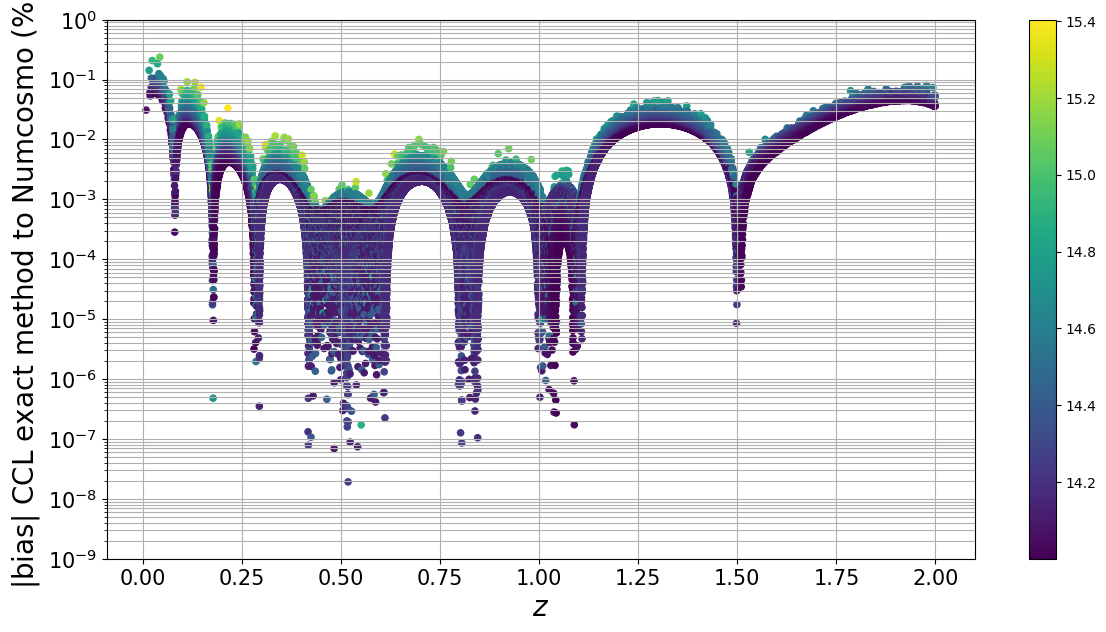

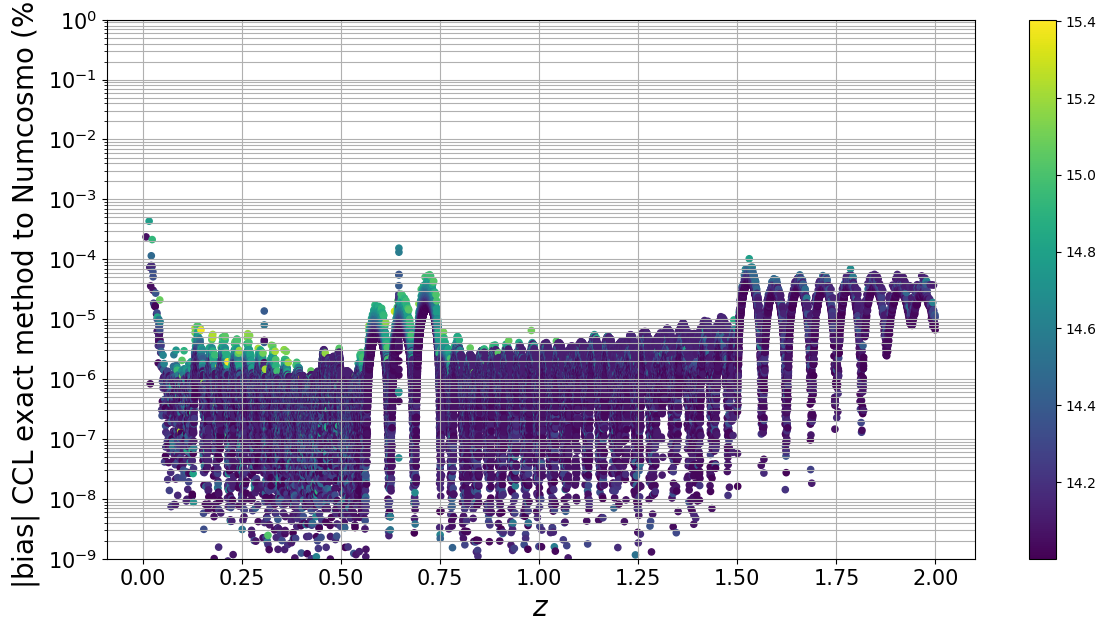

In [8]:
z = []
log10M = []
# default parameters
for i in ncdata_Table:
    z.append(i[0])
    log10M.append(i[1] / np.log(10))

diff = abs(100 * (d2n_cclcosmo_default - d2n_numcosmo) / d2n_numcosmo)

plt.figure(figsize=(14, 7))
plt.yscale("log")

plt.tick_params(axis="both", which="major", labelsize=15)

plt.scatter(z, diff, s=20, c=log10M)
plt.colorbar()
plt.grid(True, which="both")
plt.xlabel(r"$z$", fontsize=20)
plt.ylabel(r"|bias| CCL exact method to Numcosmo $(\%)$", fontsize=20)
plt.ylim(10e-10, 1)
plt.show()

# high precision parameters
diff = abs(100 * (d2n_cclcosmo_high - d2n_numcosmo) / d2n_numcosmo)

plt.figure(figsize=(14, 7))
plt.yscale("log")
plt.tick_params(axis="both", which="major", labelsize=15)

plt.scatter(z, diff, s=20, c=log10M)
plt.colorbar()
plt.grid(True, which="both")
plt.xlabel(r"$z$", fontsize=20)
plt.ylabel(r"|bias| CCL exact method to Numcosmo $(\%)$", fontsize=20)
plt.ylim(10e-10, 1)
plt.show()

<a class="anchor" id="binned"></a>
## 5.  [Binned approach](#binned)
***
In the cells above we compute the 2D integral


$$
N_{\alpha\beta}^{\rm predicted} = \Omega_s\int_{z_\alpha}^{z_{\alpha + 1}} dz\int_{\log_{10}M_\beta}^{\log_{10}M_{\beta + 1}}\frac{d^2V(z)}{dz d\Omega}\frac{dn(M,z)}{d\log_{10}M}d\log_{10}M
$$

<a class="anchor" id="mass"></a>
### 5.1 [Bins](#bins)

In the cell below we created the bins to compare the predictions in the binned case

In [ ]:
# Bins definition
z_nodes = np.linspace(0.1, 2, 9)
log10M_nodes = np.linspace(14, 14.8, 11)
lnM_nodes = log10M_nodes * np.log(10)


def binning(nodes):
    return [[nodes[i], nodes[i + 1]] for i in range(len(nodes) - 1)]


z_bins = binning(z_nodes)
log10M_bins = binning(log10M_nodes)

<a class="anchor" id="numcosmo_binned"></a>
### 5.2 [NumCosmo predictions](#numcosmo_binned)

In [ ]:
t0 = time.time()

Numcosmo_Abundance = []
ca.prepare(cosmo_numcosmo, cluster_z, cluster_m)
for zl, zu in zip(z_nodes, z_nodes[1:]):
    nc_bin_mass = []
    for lnMl, lnMu in zip(lnM_nodes, lnM_nodes[1:]):
        Pbin = ca.intp_bin_d2n(
            cosmo_numcosmo, cluster_z, cluster_m, [lnMl], [lnMu], None, [zl], [zu], None
        )
        nc_bin_mass.append(Pbin)
    Numcosmo_Abundance.append(nc_bin_mass)

# Numcosmo_Abundance[i][j] is the number of clusters in i-th z_bin and j-th mass_bin


t1 = time.time()
print("time (seconds) = " + str(t1 - t0))

<a class="anchor" id="ccl_binned"></a>
### 5.3 [CCL predictions](#ccl_binned)

In [ ]:
# CCL Cluster Abundance

# default parameters
t0 = time.time()
clc = old_cl_count.ClusterAbundance()
clc.set_cosmology(cosmo=cosmo_ccl_default, hmd=hmf_ccl, massdef=massdef)
clc.sky_area = sky_area

CCL_Abundance_default = clc.Cluster_Abundance_MZ(
    zbin_edges=z_nodes, proxybin_edges=log10M_nodes, method="exact"
)
t1 = time.time()
print("time (seconds) = " + str(t1 - t0))


# high precision parameters
t0 = time.time()
clc = old_cl_count.ClusterAbundance()
clc.set_cosmology(cosmo=cosmo_ccl_high, hmd=hmf_ccl, massdef=massdef)
clc.sky_area = sky_area

CCL_Abundance_high = clc.Cluster_Abundance_MZ(
    zbin_edges=z_nodes, proxybin_edges=log10M_nodes, method="exact"
)
t1 = time.time()
print("time (seconds) = " + str(t1 - t0))

<a class="anchor" id="plots_binned"></a>
### 5.4 [Relative error plots](#plots_binned)

In [ ]:
# default parameters
diff = []

for i in range(len(CCL_Abundance_default)):
    diff.append(
        100
        * abs(
            (Numcosmo_Abundance[i] - CCL_Abundance_default[i]) / Numcosmo_Abundance[i]
        )
    )

plt.figure(figsize=(14, 9))
plt.yscale("log")
z_ = [np.mean([z_nodes[i], z_nodes[i + 1]]) for i in np.arange(len(z_nodes) - 1)]
mass = [
    np.mean([10 ** log10M_nodes[i], 10 ** log10M_nodes[i + 1]])
    for i in np.arange(len(log10M_nodes) - 1)
]

plt.tick_params(axis="both", which="both", labelsize=15)
legend = []
for i in range(len(z_) - 1):
    plt.scatter(mass, diff[:][i])
    legend.append(str(round(z_[i], 3)) + "< z <" + str(round(z_[i + 1], 3)))
plt.legend(legend, loc=4, fontsize=10)
plt.grid(True, which="both")
plt.ylabel(r"|bias| CCL exact method to Numcosmo $(\%)$", fontsize=20)
plt.xlabel(r"$z$", fontsize=20)
# plt.ylim(1e-9, 1e-1)
plt.show()


# high precision parameters
diff = []

for i in range(len(CCL_Abundance_high)):
    diff.append(
        100
        * abs((Numcosmo_Abundance[i] - CCL_Abundance_high[i]) / Numcosmo_Abundance[i])
    )

plt.figure(figsize=(14, 9))
plt.yscale("log")
z_ = [np.mean([z_nodes[i], z_nodes[i + 1]]) for i in np.arange(len(z_nodes) - 1)]
mass = [
    np.mean([10 ** log10M_nodes[i], 10 ** log10M_nodes[i + 1]])
    for i in np.arange(len(log10M_nodes) - 1)
]

plt.tick_params(axis="both", which="both", labelsize=15)
legend = []
for i in range(len(z_) - 1):
    plt.scatter(mass, diff[:][i])
    legend.append(str(round(z_[i], 3)) + "< z <" + str(round(z_[i + 1], 3)))
plt.legend(legend, loc=4, fontsize=10)
plt.grid(True, which="both")
plt.ylabel(r"|bias| CCL exact method to Numcosmo $(\%)$", fontsize=20)
plt.xlabel(r"$z$", fontsize=20)
# plt.ylim(1e-9, 1e-1)
plt.show()